#HW5: Autoencoders

In this homework, we will explore how to develop a simple Autoencoder. As a dataset, we will use the MNIST dataset. It contains handwritten digits images.
In the first part, we will learn how to develop a simple shallow autoencoder, then we will develop a deep version. Next, we will experiment with the application of autoencoder on denoising data task (denoising-autoencoder). Finally, we will apply this model to sequential domains, considering the IMDB dataset, already used in HW4.

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

###Load Dataset
We load the MNIST dataset, using tf.keras.datasets. The dataset contains 60,000 training images and 10,000 testing images.
The value of each pixel is between 0 and 255, and it represents a point of an image of size 28 x 28. We will normalize all values between 0 and 1, and we will flatten the 28x28 images into vectors of size 784.
Finally, since no validation set is defined, we split the test set in a validation set and a new test set.

In [3]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid = x_train[:10000]
x_train = x_train[10000:]

11493376/11490434 [==============================] - 0s 0us/step


##[TO COMPLETE] Exercise 5.1: Singular Value Decomposition

Principal component analysis (PCA) and singular value decomposition (SVD) are both classical linear dimensionality reduction methods that attempt to find linear combinations of features in the original high dimensional data matrix to construct a meaningful representation of the dataset.
In this first part of the HW, we will focus our attention on SVD decomposition, a numerical stable method. Given a matrix X, the SVD decomposes it into the product of two unitary matrices V and U and a rectangular diagonal matrix of singular values S:

$$ X=V \cdot S \cdot U^T.$$

SVD is already implemented in NumPy as np.linalg.svd. In our case, the X matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features).

Note that, the X matrix in our case will have a huge number of rows (we have 50000 input samples) and only 784 columns. Therefore to optime the memory consumption, we can compute the SVD of the covariance matrix. An interesting property of the SVD is that we compute the decomposition of the covariance matrix $C= X^T \cdot X$, and we will obtain the following decomposition:

$$ C= U \cdot S^2 \cdot U^T$$

Since we need just the matrix U to compute the compressed version of our data, this method will be very convenient. If you are using the collab free plan, the quantity of available ram is not sufficient to compute the SVD of X, therefore computing the SVD of the covariance matrix turns out to be the best solution. 

In [4]:
def svd_k(X, k):
  # Compute covariance matrix
  C = np.dot(X.T, X)
  # SVD decomposition
  U, s_sqr, U_T = np.linalg.svd(C, full_matrices=False)
  # Limit the number columns of U to k
  U_k=U[:,:k]
  return U_k


Let's define the ENCODING_DIM, that will be the size of the compressed version of input data. And compute the compressed version of the training set and the test set.

**[TO COMPLETE]**: What happens varying the ENCODING_DIM? test  and discuss the results in a new cell after the following one.

In [5]:
ENCODING_DIM = 120

U_k=svd_k(x_train, ENCODING_DIM)

x_training_pca = np.dot(x_train, U_k)
x_test_pca = np.dot(x_test, U_k)



Reconstruct the input and check how much information was lost due to the compression, by computing the mean squared error between the original input and the reconstruction, and by plotting the reconstructed images.

In [6]:
x_training_reco= np.dot(x_training_pca, U_k.T)
x_test_reco= np.dot(x_test_pca, U_k.T)




In [7]:
accuracy_train = ((x_train - x_training_reco)**2).mean()
accuracy_test = ((x_test - x_test_reco)**2).mean()

print("training mse: %.5f" % ( accuracy_train))
print("test mse: %.5f" % ( accuracy_test))

training mse: 0.00464
test mse: 0.00455


In [8]:
def plot_img(n, input_data, decoded_imgs):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(input_data[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

Let's check how well the input can be reconstructed by printing a few of the input images and the corresponding reconstructions. Obviously, all these evaluations have to be done on the test set.

The first row of shown images corresponds to input data, while the second one contains the reconstructions.

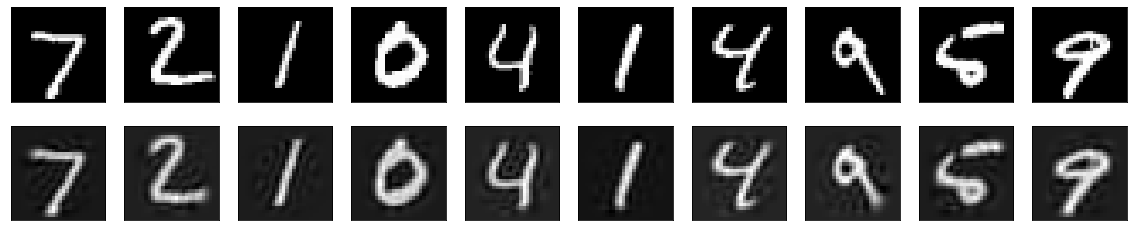

In [9]:
plot_img(10, x_test, x_test_reco)

[Answer:]

Different value of ENCODING VALUE ( let me call encoding value as k ) : 
- k = 1 : This is the lowest value that i test. This mean that i take the most significant principal feature of decomposition. The result of this shows a indistinguishable number in center and black backgrond. Infact, according pca, this is The most important feature(with k=1)
-k = 20,30,40,50 : 
More feature we take, it going to show us more details in the center of image. The reconstructed images looks a bit blurried, but the numbers are very distinguishable
-k=120 : the output images look very detailed



## [TO COMPLETE] Exercise 5.2: Shallow Linear Autoencoder
Let's define a model that consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively. Differently than the previous homework, instead of using Keras.Sequential(), we define the various part of the model (encoder and decoder) separately and then we create the final model. 

**[TO COMPLETE]** check the results and compare them versus the results obtained with the SVD. Add a cell  at the end of this section (after the result of the linear autoencoder) where you give an explanation of the relation between the results obtained  by the shallow linear autoencoder and the ones obtained by the SVD decomposition.


In [10]:
ENCODING_DIM = 120

input_img = tf.keras.layers.Input(shape=(784,))
#Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)

#...and the decoder...
decoded = tf.keras.layers.Dense(784, activation='linear')(encoded)

#and finally the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

#Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')


Print the model summary.

In [11]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 120)               94200     
_________________________________________________________________
dense_1 (Dense)              (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________


Train the model.

In [12]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
98/98 [==============================] - 2s 18ms/step - loss: 0.0792 - val_loss: 0.0139
Epoch 2/15
98/98 [==============================] - 1s 14ms/step - loss: 0.0121 - val_loss: 0.0084
Epoch 3/15
98/98 [==============================] - 1s 14ms/step - loss: 0.0082 - val_loss: 0.0067
Epoch 4/15
98/98 [==============================] - 1s 14ms/step - loss: 0.0065 - val_loss: 0.0059
Epoch 5/15
98/98 [==============================] - 1s 14ms/step - loss: 0.0058 - val_loss: 0.0055
Epoch 6/15
98/98 [==============================] - 1s 14ms/step - loss: 0.0055 - val_loss: 0.0052
Epoch 7/15
98/98 [==============================] - 1s 15ms/step - loss: 0.0052 - val_loss: 0.0051
Epoch 8/15
98/98 [==============================] - 1s 14ms/step - loss: 0.0055 - val_loss: 0.0050
Epoch 9/15
98/98 [==============================] - 1s 14ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 10/15
98/98 [==============================] - 1s 14ms/step - loss: 0.0055 - val_loss: 0.0050
Epoch 11/

Plot the loss and the accuracy curves on the validation set, and the accuracy on the test set.


In [13]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

313/313 - 0s - loss: 0.0050
test mse: 0.00500


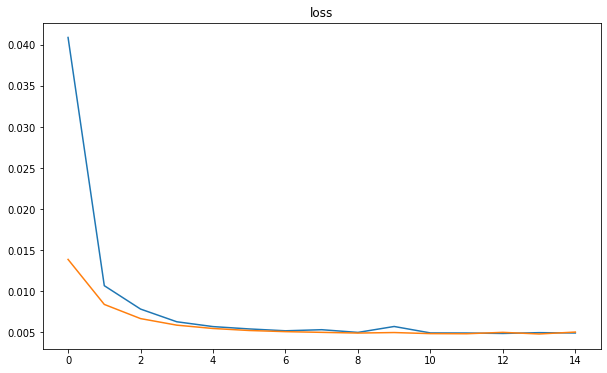

In [14]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

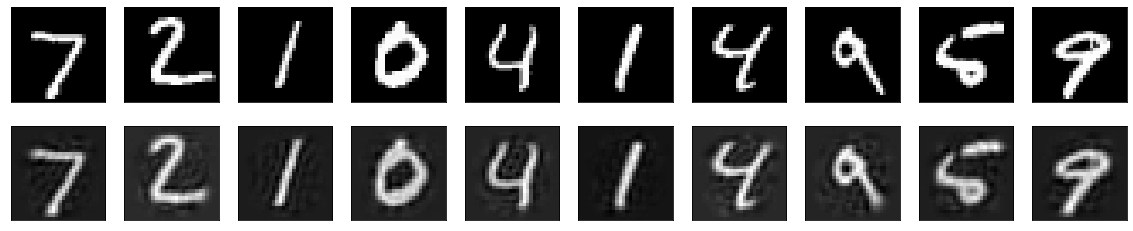

In [15]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, x_test, decoded_imgs)


[Answer]

-In both case the output images are very close to the original and the numbers are perfectly distinguishable.

-The mean square errore are very close :  mse shallow linear autodecoder= 0.00501, mse svd=0.00464








##[TO COMPLETE] Exercise 5.3: Shallow non-linear autoencoders

**[TO COMPLETE]** replicate the code of Exercise 5.1 but in this case, instead of using linear activation functions use  non-linear ones. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained in Exercise 5.1. (Insert your code and  theoretical discussion into  cells immediately below this one.)


In [16]:
ENCODING_DIM = 120

input_img = tf.keras.layers.Input(shape=(784,))
#Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_img)

#...and the decoder...
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)

#and finally the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

#Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')


history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0757 - val_loss: 0.0350
Epoch 2/15
98/98 [==============================] - 2s 15ms/step - loss: 0.0314 - val_loss: 0.0224
Epoch 3/15
98/98 [==============================] - 1s 15ms/step - loss: 0.0207 - val_loss: 0.0163
Epoch 4/15
98/98 [==============================] - 1s 15ms/step - loss: 0.0154 - val_loss: 0.0128
Epoch 5/15
98/98 [==============================] - 1s 15ms/step - loss: 0.0123 - val_loss: 0.0106
Epoch 6/15
98/98 [==============================] - 1s 15ms/step - loss: 0.0103 - val_loss: 0.0092
Epoch 7/15
98/98 [==============================] - 1s 15ms/step - loss: 0.0089 - val_loss: 0.0082
Epoch 8/15
98/98 [==============================] - 1s 15ms/step - loss: 0.0080 - val_loss: 0.0073
Epoch 9/15
98/98 [==============================] - 1s 15ms/step - loss: 0.0072 - val_loss: 0.0067
Epoch 10/15
98/98 [==============================] - 1s 15ms/step - loss: 0.0065 - val_loss: 0.0062
Epoch 11/

313/313 - 0s - loss: 0.0044
test mse: 0.00445


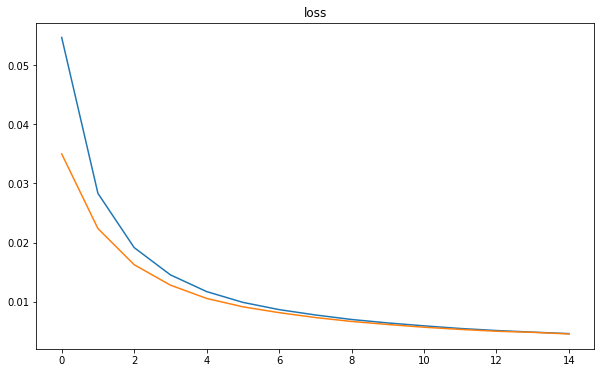

In [17]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

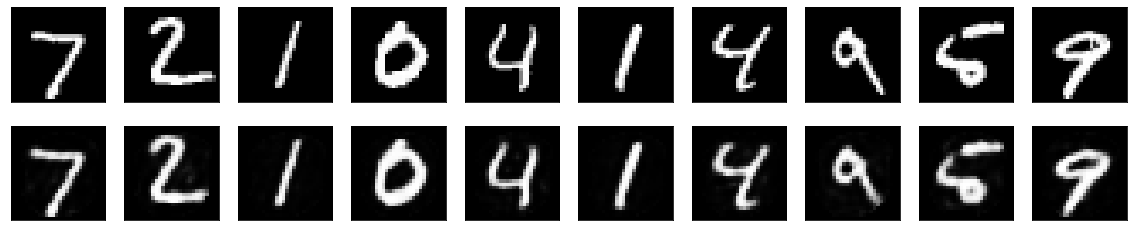

In [18]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, x_test, decoded_imgs)

Answer : 
-After many attemps, using tanh, sigmoid, ReLu,  i choose sigmoid because that gave me the better result.

-As we can see, sigmoide provides a better representation (less blurred)

##[TO COMPLETE] Exercise 5.4: Deep Autoencoder
**[TO COMPLETE]**: Define a deep version of the Autoeancoder defined above. The autoencoder has to use at least 5 layers. The model will use $n$ layers for encoding, and n-1 for decoding. The layers sizes of the encoding part decrease at each layer (i.e. 784->128->64, where 64 is the encoding dim). The decoding part layers dimensions progression turns out to be mirrored (i.e 128->784, the resulting overall structure recalls an hourglass).
Similarly than what we did above, print the model summary, the loss curves during the training, the achieved loss on the test set, and some input images with the corresponding decoding.


In [19]:
input_img = tf.keras.layers.Input(shape=(784,))

encoded = tf.keras.layers.Dense(256, activation ='selu')(input_img)
encoded = tf.keras.layers.Dense(128, activation = 'selu')(encoded)
encoded = tf.keras.layers.Dense(64, activation = 'selu')(encoded)

decoded = tf.keras.layers.Dense(128, activation ='selu')(encoded)
decoded = tf.keras.layers.Dense(256, activation ='selu')(decoded)
decoded = tf.keras.layers.Dense(784, activation ='sigmoid')(decoded)

#autoencoder = tf.keras.models.Model()#[TO COMPLETE]

autoencoder = tf.keras.models.Model(input_img, decoded)


autoencoder.compile(optimizer='adam', loss='mse')

In [20]:
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_8 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_9 (Dense)              (None, 784)               2014

In [21]:
history = autoencoder.fit(x_train, x_train, epochs= 15, batch_size= 250*2, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
100/100 [==============================] - 4s 32ms/step - loss: 0.0854 - val_loss: 0.0299
Epoch 2/15
100/100 [==============================] - 3s 30ms/step - loss: 0.0266 - val_loss: 0.0190
Epoch 3/15
100/100 [==============================] - 3s 30ms/step - loss: 0.0178 - val_loss: 0.0144
Epoch 4/15
100/100 [==============================] - 3s 30ms/step - loss: 0.0138 - val_loss: 0.0119
Epoch 5/15
100/100 [==============================] - 3s 30ms/step - loss: 0.0117 - val_loss: 0.0106
Epoch 6/15
100/100 [==============================] - 3s 30ms/step - loss: 0.0104 - val_loss: 0.0097
Epoch 7/15
100/100 [==============================] - 3s 30ms/step - loss: 0.0096 - val_loss: 0.0091
Epoch 8/15
100/100 [==============================] - 3s 30ms/step - loss: 0.0090 - val_loss: 0.0086
Epoch 9/15
100/100 [==============================] - 3s 30ms/step - loss: 0.0085 - val_loss: 0.0081
Epoch 10/15
100/100 [==============================] - 3s 30ms/step - loss: 0.0080 - val_lo

313/313 - 1s - loss: 0.0063
test mse: 0.00633


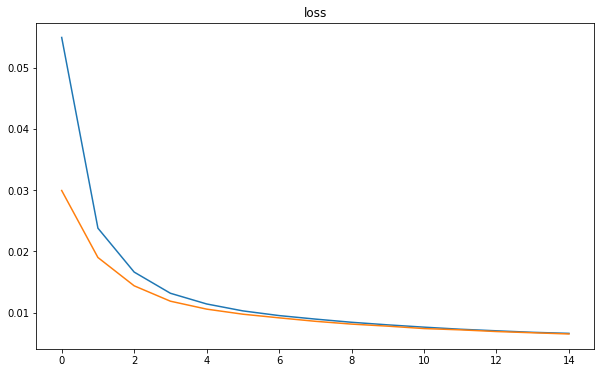

In [22]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

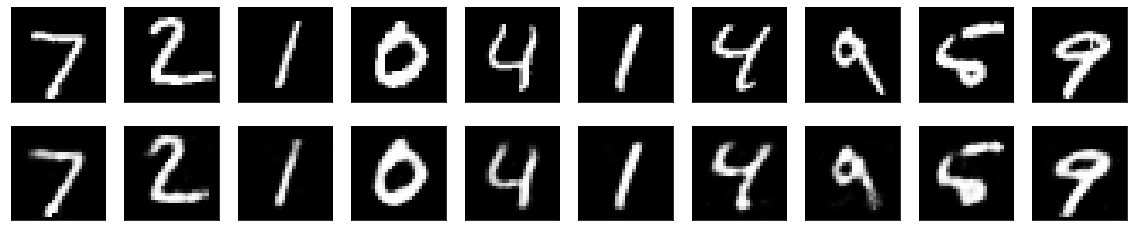

In [23]:
decoded_imgs = autoencoder.predict(x_test)

plot_img(10, x_test, decoded_imgs)


## [TO COMPLETE] Exercise 5.5: Denoising Autoencoder

Let's now use a shallow autoencoder to denoise the input data.
Firstly, define a noisy input by adding some noise to our input data. We define a noise factor that can be used to modify the amount of noise to add to the input data. Check how much it influences the denoising capability of the autoencoder.

In [24]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid, y_valid = x_train[:10000],y_train[:10000]
x_train, y_train = x_train[10000:],y_train[10000:]

noise_factor = 0.3

x_train_noisy = x_train + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_valid_noisy = x_valid + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_valid.shape)


x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)

Plot some noisy inputs.

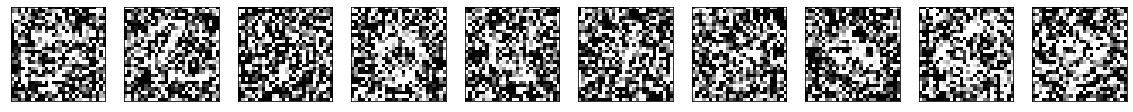

In [25]:
# here's what the noisy digits look like
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**[TO COMPLETE]** Define a shallow autoencoder able to compute a de-noised version of the input (obtained by unsing a noise_factor >= 0.3). 

In [26]:
input_img = tf.keras.layers.Input(shape=(784,))

encoded = tf.keras.layers.Dense(256, activation ='selu')(input_img)
encoded = tf.keras.layers.Dense(128, activation = 'selu')(encoded)
encoded = tf.keras.layers.Dense(64, activation = 'selu')(encoded)

decoded = tf.keras.layers.Dense(128, activation ='selu')(encoded)
decoded = tf.keras.layers.Dense(256, activation ='selu')(decoded)
decoded = tf.keras.layers.Dense(784, activation ='sigmoid')(decoded)

#autoencoder = tf.keras.models.Model()#[TO COMPLETE]

autoencoder = tf.keras.models.Model(input_img, decoded)


autoencoder.compile(optimizer='adam', loss='mse')



In [27]:
autoencoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_11 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_13 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_14 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_15 (Dense)             (None, 784)               2014

**[TO COMPLETE]** Train the model by passing the noisy input and the clean target.

In [28]:
history = autoencoder.fit(x_train_noisy, x_train, epochs=15, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)], batch_size=512, shuffle=True, validation_data=(x_valid_noisy, x_valid))

Epoch 1/15
98/98 [==============================] - 4s 32ms/step - loss: 0.0982 - val_loss: 0.0615
Epoch 2/15
98/98 [==============================] - 3s 31ms/step - loss: 0.0586 - val_loss: 0.0492
Epoch 3/15
98/98 [==============================] - 3s 31ms/step - loss: 0.0480 - val_loss: 0.0448
Epoch 4/15
98/98 [==============================] - 3s 31ms/step - loss: 0.0442 - val_loss: 0.0419
Epoch 5/15
98/98 [==============================] - 3s 30ms/step - loss: 0.0416 - val_loss: 0.0406
Epoch 6/15
98/98 [==============================] - 3s 30ms/step - loss: 0.0398 - val_loss: 0.0392
Epoch 7/15
98/98 [==============================] - 3s 30ms/step - loss: 0.0387 - val_loss: 0.0381
Epoch 8/15
98/98 [==============================] - 3s 31ms/step - loss: 0.0376 - val_loss: 0.0374
Epoch 9/15
98/98 [==============================] - 3s 31ms/step - loss: 0.0369 - val_loss: 0.0372
Epoch 10/15
98/98 [==============================] - 3s 31ms/step - loss: 0.0360 - val_loss: 0.0363
Epoch 11/

313/313 - 1s - loss: 0.0341
test mse: 0.03408


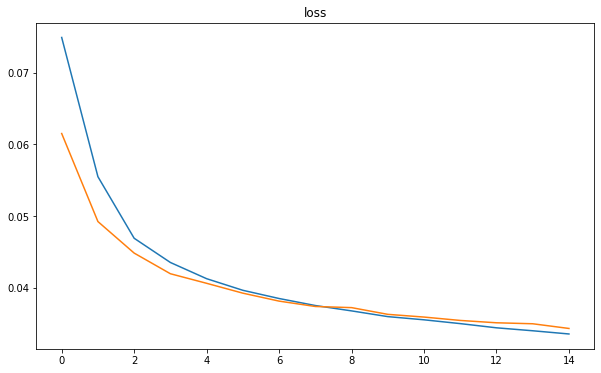

In [29]:
plot_loss(history)

scores = autoencoder.evaluate(x_test_noisy, x_test, verbose=2)
print("test mse: %.5f" % (scores))

**[TO COMPLETE]** Check the result by plotting some input images and the corresponding denoised outputs.

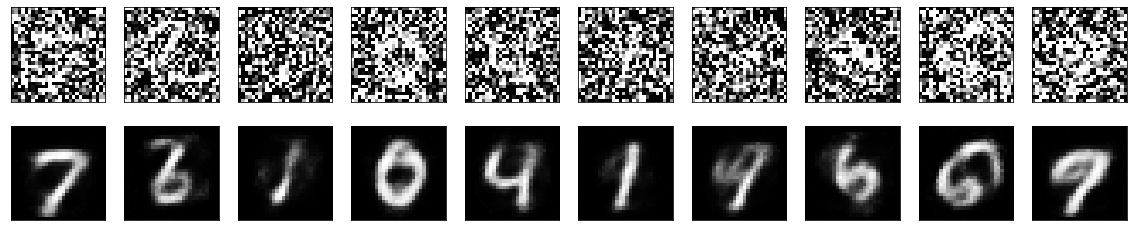

In [30]:
decoded_imgs = autoencoder.predict(x_test_noisy)

plot_img(10, x_test_noisy, decoded_imgs)

## Exercise 5.6: Linear Autoencoder for sequences

Let's define a linear autoencoder for sequences. In this case, as dataset, we will use the IMDB dataset (already presented in HW4). To have a model that can be trained and tested in a reasonable time (and that works also with the memory limitation that we have in Colab), we will limit the number of training samples and test samples.

In [31]:
num_words = 100
(X_train, _), (X_test, _) = keras.datasets.imdb.load_data(num_words=num_words)

X_train=X_train[:10000]

(X_valid, X_test) = X_test[:1250], X_test[-1250:]

word_index = keras.datasets.imdb.get_word_index()

reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])


maxlen = 90
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)



17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


1646592/1641221 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In this case, we want to use as input/target a one-hot representation for each word. To convert the index representation provided by IMDB dataset loader we use the to_categorical method to transform them in the corresponding one hot representation.

In [32]:
from keras.utils import to_categorical


X_train_one_hot=to_categorical(X_train_trim)
X_test_one_hot=to_categorical(X_test_trim)
X_valid_one_hot=to_categorical(X_valid_trim)


Define a linear shallow autoencoder for sequences. The structure will be similar to the model defined in Exercise 5.2, while the used encoding layer is defined by using tf.keras.layers.SimpleRNN. Note that it uses linear activations. The decoding layer exploits [tf.keras.layers.TimeDistributed](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) that allows using the same dense cell at each time step of the sequence. 

In [33]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='linear')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='linear'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 90, 100)]         0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 90, 50)            7550      
_________________________________________________________________
time_distributed (TimeDistri (None, 90, 100)           5100      
Total params: 12,650
Trainable params: 12,650
Non-trainable params: 0
_________________________________________________________________


In [34]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 7s 75ms/step - loss: 0.3689 - categorical_accuracy: 0.0475 - val_loss: 0.0933 - val_categorical_accuracy: 0.3332
Epoch 2/50
79/79 [==============================] - 6s 72ms/step - loss: 0.0823 - categorical_accuracy: 0.4048 - val_loss: 0.0691 - val_categorical_accuracy: 0.4567
Epoch 3/50
79/79 [==============================] - 6s 72ms/step - loss: 0.0649 - categorical_accuracy: 0.4693 - val_loss: 0.0601 - val_categorical_accuracy: 0.4869
Epoch 4/50
79/79 [==============================] - 6s 73ms/step - loss: 0.0577 - categorical_accuracy: 0.5068 - val_loss: 0.0560 - val_categorical_accuracy: 0.5373
Epoch 5/50
79/79 [==============================] - 6s 73ms/step - loss: 0.0534 - categorical_accuracy: 0.5526 - val_loss: 0.0507 - val_categorical_accuracy: 0.5585
Epoch 6/50
79/79 [==============================] - 6s 72ms/step - loss: 0.0484 - categorical_accuracy: 0.5745 - val_loss: 0.0465 - val_categorical_accuracy: 0.5822
Epoch 7/50

Let's plot the accuracy and the loss trends and check the reconstruction capability of the model by plotting the reconstruction of a test sample

40/40 - 0s - loss: 0.0126 - categorical_accuracy: 0.9259
categorical_accuracy: 92.59%


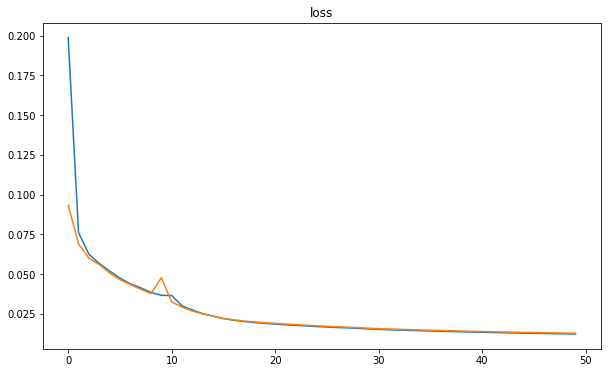

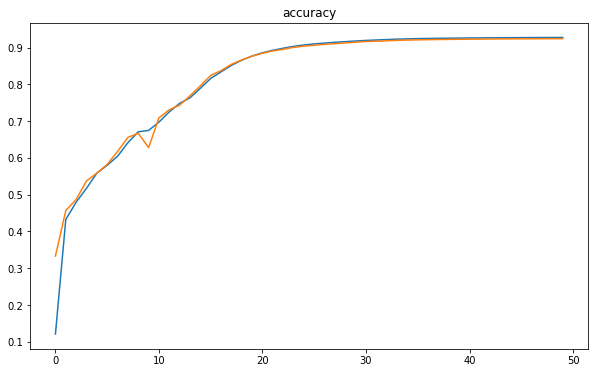

In [35]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [36]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a movie <oov> film in just if <oov> <oov> <oov> <oov> as of on <oov> have <oov> out it <oov> has <oov> <oov> of the film are <oov> <oov> film <oov> really <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> well <oov>


##[TO COMPLETE] Exercise 5.7: Non-Linear Autoencoder for sequences
**[TO COMPLETE]**: Replicate the code of the above exercise, but instead of using a simpleRNN with linear activation do the same  using  non-linear activation functions and using an LSTM layer. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained by the linear autoencoder for sequences.

Hint: using a non-linear function also in the dense layer after the RNN/LSTM one will help to obtain better results. The choice of this function should be based on the type of output data.

In [45]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.LSTM(50, activation='sigmoid', return_sequences=True)(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='sigmoid'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 90, 100)]         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 90, 50)            30200     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 90, 100)           5100      
Total params: 35,300
Trainable params: 35,300
Non-trainable params: 0
_________________________________________________________________


In [51]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=30, batch_size=256, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/30
40/40 [==============================] - 10s 243ms/step - loss: 0.0022 - categorical_accuracy: 0.9815 - val_loss: 0.0021 - val_categorical_accuracy: 0.9839
Epoch 2/30
40/40 [==============================] - 10s 240ms/step - loss: 0.0019 - categorical_accuracy: 0.9868 - val_loss: 0.0018 - val_categorical_accuracy: 0.9882
Epoch 3/30
40/40 [==============================] - 10s 242ms/step - loss: 0.0017 - categorical_accuracy: 0.9913 - val_loss: 0.0016 - val_categorical_accuracy: 0.9927
Epoch 4/30
40/40 [==============================] - 10s 241ms/step - loss: 0.0014 - categorical_accuracy: 0.9944 - val_loss: 0.0014 - val_categorical_accuracy: 0.9956
Epoch 5/30
40/40 [==============================] - 10s 240ms/step - loss: 0.0012 - categorical_accuracy: 0.9965 - val_loss: 0.0012 - val_categorical_accuracy: 0.9971
Epoch 6/30
40/40 [==============================] - 10s 240ms/step - loss: 0.0011 - categorical_accuracy: 0.9975 - val_loss: 0.0010 - val_categorical_accuracy: 0.997

In [ ]:
plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [ ]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>


-Softmax as activation because it is a classification problem.



-Compare to the linear one: this model performs better BUT it is also more complex

-We can notice the number of parameters is almost tripled (12650--> 35300)